In [52]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Load Test Piece

In [31]:
from virtuoso import inference
import pickle
with open('dataset_section_tempo/stat.dat', 'rb') as f:
  stat = pickle.load(f)
graph_keys = ['onset', 'forward', 'melisma', 'rest', 'voice']
score, score_features, edges, note_locations = inference.get_input_from_xml(
                                              'test_pieces/schumann/musicxml_cleaned.musicxml', 
                                               'Schumann',
                                               None, 
                                               stat['input_keys'],
                                               graph_keys,
                                               stat['stats'],
                                               device='cpu'
                                              )

In [49]:
end_duration = max([note.note_duration.xml_position+note.note_duration.duration for note in score.xml_notes])

piano_roll = torch.zeros(88, end_duration)
for note in score.xml_notes:
  piano_roll[note.pitch[1]-21,
             note.note_duration.xml_position:note.note_duration.xml_position+note.note_duration.duration+1] = 1
piano_roll

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

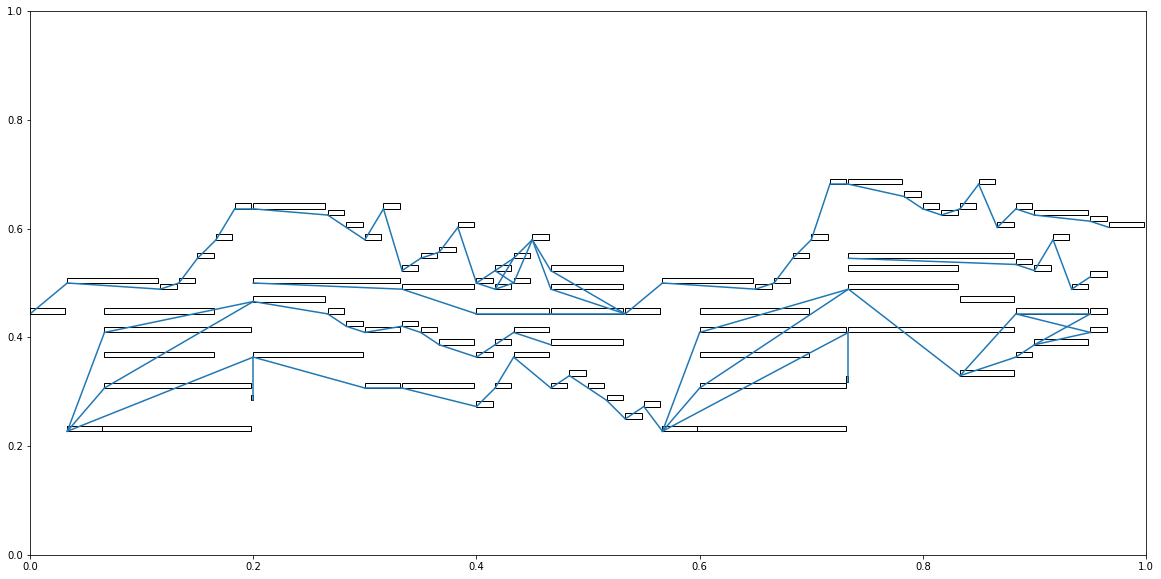

In [153]:
import matplotlib.patches as patches
import matplotlib.lines as lines

def draw_piano_roll(xml_notes, figsize=(20,10), edges=None, target_edge_type=0):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111, aspect='auto')
  start_position = xml_notes[0].note_duration.xml_position
  total_duration = max([note.note_duration.xml_position+note.note_duration.duration for note in xml_notes]) - start_position
  for note in xml_notes:
    pitch = note.pitch[1]-21
    position = (note.note_duration.xml_position-start_position) / total_duration
    ax.add_patch(
       patches.Rectangle(
          (position, pitch/88),
          note.note_duration.duration / total_duration - 0.002,
          0.01,
          fill=False      # remove background
       ) ) 
  if isinstance(edges, torch.Tensor):
    for edge_type, start, end in  zip(*torch.where(edges)):
      if edge_type==target_edge_type:
        note_a = xml_notes[start]
        note_b = xml_notes[end]
        x_info = ((note_a.note_duration.xml_position-start_position) / total_duration,
                (note_b.note_duration.xml_position-start_position) / total_duration
                 )
        y_info = ((note_a.pitch[1]-21)/88, (note_b.pitch[1]-21)/88)
        line = lines.Line2D(x_info, y_info)
        ax.add_line(line)

start_note_idx = 0
num_notes = 100
draw_piano_roll(score.xml_notes[start_note_idx:start_note_idx+num_notes], 
                edges=edges[:,start_note_idx:start_note_idx+num_notes,start_note_idx:start_note_idx+num_notes],
               target_edge_type=4)

## 1. Test Gated Graph Neural Net

In [158]:
score_features.shape

torch.Size([1, 479, 78])

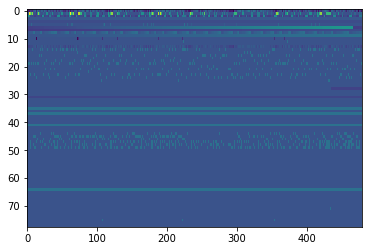

In [170]:
plt.imshow(score_features[0].T, aspect='auto', interpolation='nearest')

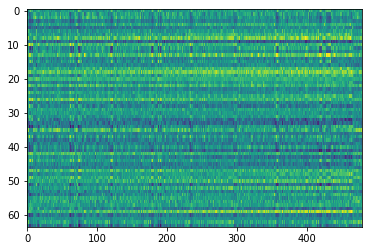

In [174]:
import torch.nn as nn
torch.manual_seed(0)
linear = nn.Linear(78, 64)

linear_out = linear(score_features)
plt.imshow(linear_out[0].detach().T, aspect='auto', interpolation='nearest')

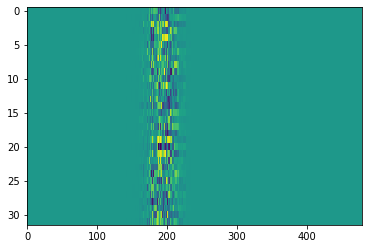

In [225]:
from virtuoso.module import GatedGraph, GatedGraphX
torch.manual_seed(0)
gated = GatedGraphX(64, 32, 10)
hidden = torch.zeros(1,479,32)
hidden[0,200,:] = torch.randn(32)
linear_out[0] = 0
for i in range(5):
  hidden = gated(linear_out, hidden, edges, iteration=1)
plt.imshow(hidden[0].detach().T, aspect='auto', interpolation='nearest')

In [208]:
linear_out

tensor([[[-0.2271, -0.1804,  0.2655,  ..., -0.0469,  0.1949, -0.0961],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<CopySlices>)

In [204]:
torch.min(hidden), torch.max(hidden)

(tensor(-1., grad_fn=<MinBackward1>), tensor(1., grad_fn=<MaxBackward1>))